# Finetuning AlexNet for Volcanic Deformation Classification

<a target="_blank" href="https://colab.research.google.com/github/AI4EPS/EPS88_PyEarth/blob/master/docs/lectures/11_neural_networks3.ipynb">
<img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  

**Note**: If you are running this in [a colab notebook](https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb), we recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

This tutorial demonstrates how to fine-tune a pre-trained AlexNet model on the LICS dataset, which consists of volcanic InSAR (Interferometric Synthetic Aperture Radar) images. 

The dataset contains 6,808 images, divided into two categories: 3,605 images displaying deformation signals (class 1 'volcano_deformation') and 3,203 images without deformation signals (class 0 'background_noise'). Originally, the pre-trained AlexNet was designed to classify 1,000 types of natural objects, such as tables, cars, dogs, etc. 

In this tutorial, we will modify the final layer of the neural network to classify images into just two classes instead of the original 1,000.

<img src='https://raw.githubusercontent.com/zhuwq0/images/main/alexnet.png' style='width: 50%'/>

Created by Robert Gabriel Popescu and Juliet Biggs, University of Bristol, UK.

## LiCS Dataset ##

<!-- You can download the dataset at [LiCS dataset](https://zenodo.org/records/14161590) or by pressing on this link: [download](https://zenodo.org/records/14161590/files/LiCS.zip).  -->

Download and Unzip the dataset and make sure the folder *LiCS* has two subfolders: *background_noise* and *volcano_deformation*.

In [1]:
%%capture
import os
if not os.path.exists('LiCS'):
    if not os.path.exists('LiCS.zip'):
        !wget https://github.com/AI4EPS/EPS88_PyEarth/releases/download/LiCS/LiCS.zip
    !unzip LiCS.zip
else:
    print("File already exists.")

## Imports ##

We will import the necessary libraries:
- *torch* is the main library that will run the Artificial neural network, called **PyTorch**
- *matplotlib* is for creating graphs
- *numpy* is for storying arrays of data. A few other libraries work only with this (such as matplotlib)
- *sklearn* is a machine learning library that we will use to separate the dataset into train and test
- *torchvision* is a library for loading images as datasets to be used by **PyTorch**

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from tqdm import tqdm
from collections import Counter
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import random

In [3]:
## Set random seed
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)

## Running the models on the GPU ##
We want to run the code on the GPU if possible. Artifial neural networks work faster on a GPU so we will select the device **cuda** if it is available. Alternatively, if you are using a Mac, you want to select **mps**.

If you encounter problems with the memory, manually setting this to the CPU will solve the problem, but it will also slow down the training process. 

In [4]:
# We run the model on the GPU if possible
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# If you get errors about CUDA running out of memory, you can set it to run on the CPU by uncommenting the next line.
# device = torch.device("cpu")
print(device)

mps


## Loading the dataset ##
We will load the **LICS** dataset that contains two folders, one with images of **volcano deformation** and one with images of **background noise**. If the dataset is not in the same folder as this notebook, change *dataset_dir* to the correct path of the dataset.

We need to define the transformations that will be applied to the images. In this case, we will only transform the images into **tensors**, which is how **PyTorch** stores and uses data. This will also bring the images from the interval [0,255] (the interval used to store RGB images) to [0,1]. Neural networks work better with small numbers, ideally between the interval [-1,1] or [0,1].

Tensors are a specialized data structure that is similar to arrays and matrices. Tensors are used to encode the inputs and outputs of a model, as well as the parameters of the model. Tensors are similar to NumPy’s ndarrays, except that tensors can run on GPUs or other hardware accelerators. They are also optimized for automatic differentiation.

In [5]:
# Path to the dataset
dataset_dir = 'LiCS'

# Transformers applied to the dataset
data_transforms = transforms.Compose([
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root=dataset_dir, transform=data_transforms)
class_names = dataset.classes

# Show information about the dataset
print(f'Dataset size: {len(dataset)}')
print(f'Mapping from class names to indexes: {dataset.class_to_idx}')
print(f'Number of samples per class: {dict(Counter(dataset.targets))}')

Dataset size: 6808
Mapping from class names to indexes: {'background_noise': 0, 'volcano_deformation': 1}
Number of samples per class: {0: 3203, 1: 3605}


## Visualizing the dataset ##

We will create a function to visualize some of the images inside the dataset. Then we will load some images using the train dataloader and visualize them.

The images are wrapped InSAR interferograms. Each fringe represents 2.8 cm of displacement. The images are automatically processed from satellite data. You can read more about InSAR images [here](https://en.wikipedia.org/wiki/Interferometric_synthetic-aperture_radar).

Watch this video to understand how InSAR works: [link](https://youtu.be/SLMWzQQv90s?si=byqpNh92ikN0xOrq)


In [6]:
def plot_example(images, labels, show_labels=False):
    num_cols = 4
    num_rows = (len(images) - 1) // num_cols + 1
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows), squeeze=False)
    for i in range(num_rows):
        for j in range(num_cols):
            idx = i * num_cols + j
            if idx < len(images):
                image = images[idx][0]
                image = image * 2 * np.pi - np.pi
                axs[i, j].imshow(image, cmap='jet', vmin=-np.pi, vmax=np.pi)
                if show_labels:
                    axs[i, j].set_title(class_names[labels[idx]])
                axs[i, j].axis('off')
            else:
                axs[i, j].axis('off')
    plt.show()

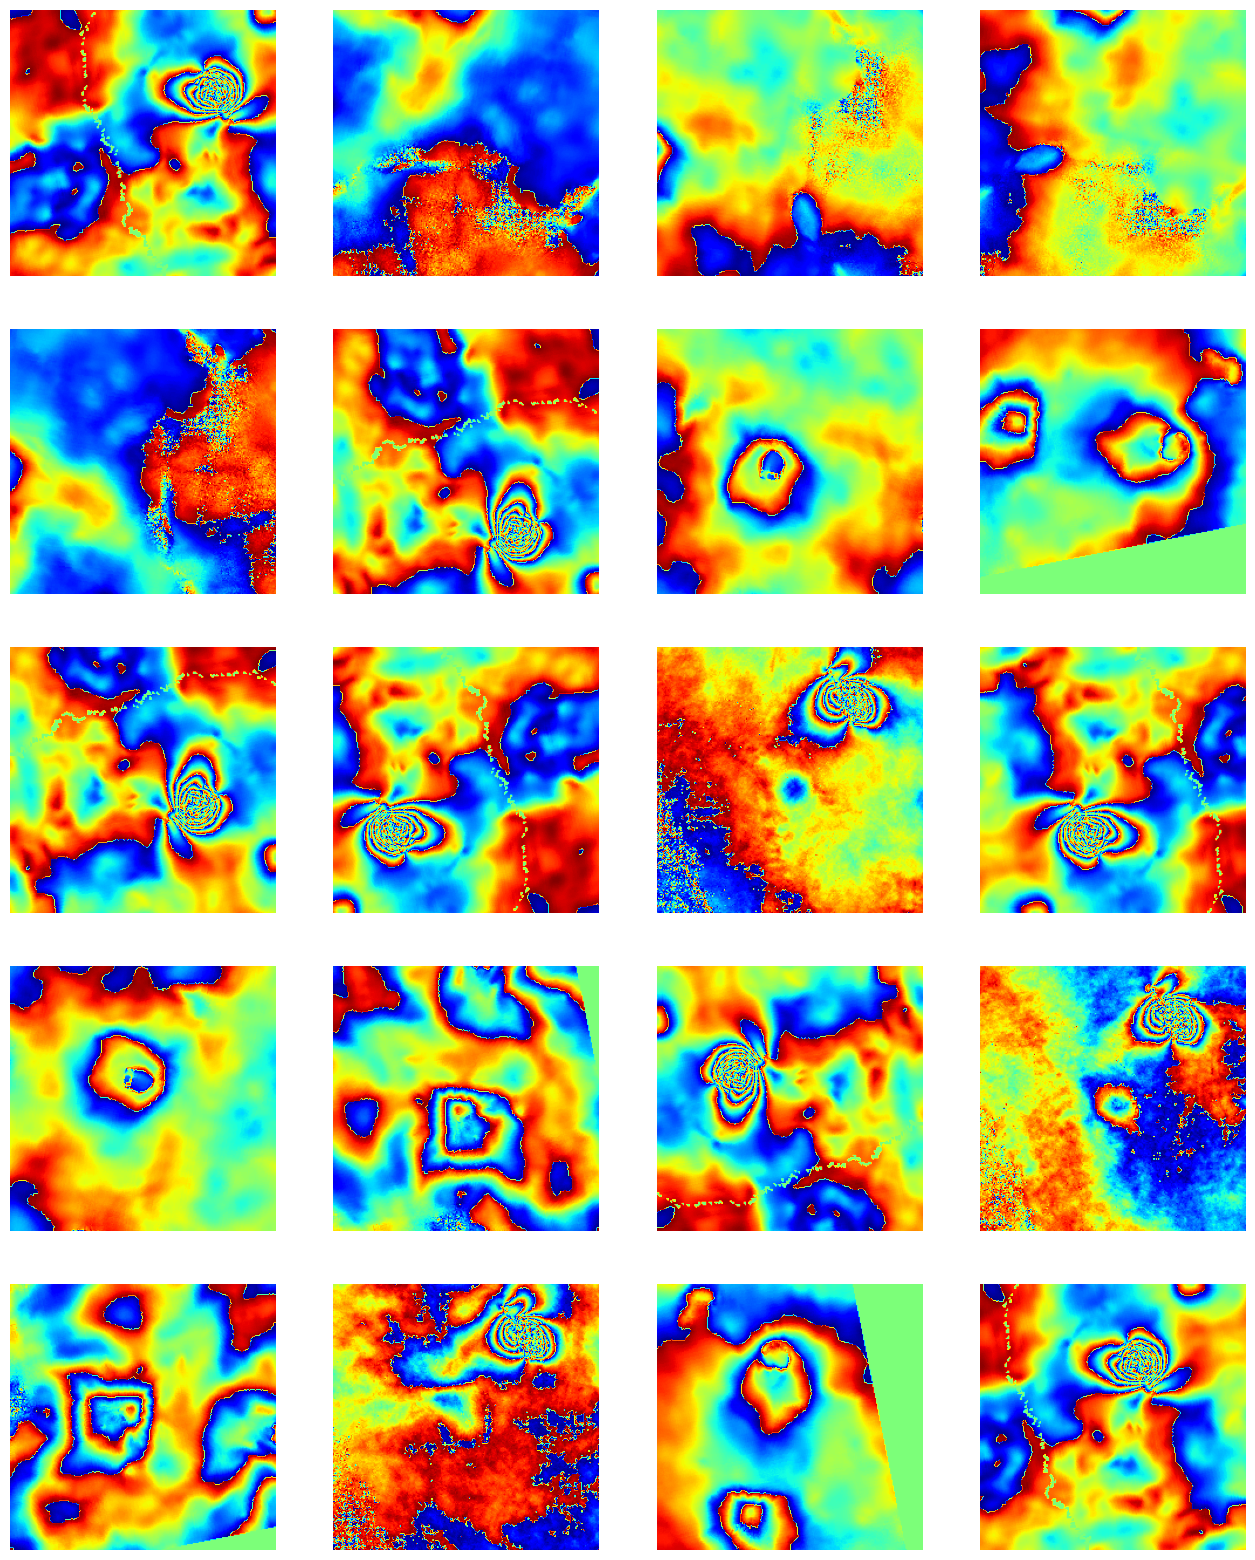

In [7]:
num_samples_per_class = 10
noise_indices = [i for i, label in enumerate(dataset.targets) if label == 0][:num_samples_per_class]
volcano_indices = [i for i, label in enumerate(dataset.targets) if label == 1][:num_samples_per_class]
indices = noise_indices + volcano_indices
random.shuffle(indices)
images, labels = zip(*[dataset[i] for i in indices])
plot_example(images, labels, show_labels=False)

Question: Based on the images, can you tell which images are from the class 'volcano_deformation' and which are from the class 'background_noise'? How can you tell the difference?


Question: Pass ```show_labels=True``` to the function and run the code again to show the ground truth labels of the images. Do the labels match your prediction?


Now let's see if we can also train a neural network to differentiate between the two classes. 
If we can, we can use this neural network to automatically detect volcanic deformation signals in InSAR images.
As you can imagine, the InSAR satellites are taking thousands of images every day, and it is impossible for a human to look at all of them. This is where the neural network and machine learning come in handy.

Recall what we learned in the previous lectures about neural networks. We will folow a similar approach to build a neural network that can differentiate between the two classes of images for automatic detection of volcanic deformation signals.

## Splitting the dataset into train and test ##

**PyTorch** allows us to split a dataset into two parts only at random, so if we want to have the same number of images from each class into both the train and the test dataset, we need to use a function from **sklearn**: *train_test_split*.

In general, the size of the test dataset is much smaller than the training dataset. Here we use a training dataset that is ten times bigger than the test. The optimum split depends on the use case, the model used, the size of the dataset, etc., but a generally good split is 80% train and 20% test.

In [8]:
train_dataset_size = 2000
test_dataset_size = 200

targets = np.array(dataset.targets)
# The two classes are unbalanced with 'volcano_deformation' having more images. Thus we remove some of them. 
# All the 3203 'background_noise' images are in front, followed by the 3605 'volcano_deformation' images. 
# So from the array with all the images, we can select the first 6406 images, which is all the 'background_noise' ones followed by 3203 'volcano_deformation' ones.
# Thus, we select the first 6406 images from the dataset.
targets = targets[:6406]
train_indices, test_indices = train_test_split(
    np.arange(targets.shape[0]),
    train_size=train_dataset_size,
    test_size=test_dataset_size,
    stratify=targets,
)

# We use the splits we obtained to create subsets of the main dataset, one for train and one for test
train_dataset = Subset(dataset, indices=train_indices)
test_dataset = Subset(dataset, indices=test_indices)

# Show information about our subsets
train_classes = [dataset.targets[i] for i in train_dataset.indices]
print(f'Numner of samples per class for the train dataset: {dict(Counter(train_classes))}')

test_classes = [dataset.targets[i] for i in test_dataset.indices]
print(f'Numner of samples per class for the test dataset: {dict(Counter(test_classes))}')

Numner of samples per class for the train dataset: {0: 1000, 1: 1000}
Numner of samples per class for the test dataset: {1: 100, 0: 100}


## Creating a DataLoader ##

A **DataLoader** is responsible for loading the data, in our case images, from the disk into memory during training or testing. 

We need to decide how many images are loaded at once by setting *batch_size*. The *batch_size* option influences how fast and efficient the model trains, but a bigger batch size also means more memory is required. A bigger batch size can also yield higher accuracy.

The argument *shuffle* decides if the order in which the images are loaded is random or not. We will make the order random for training but not for testing. Making the order random when training can boost the final accuracy of the model.

Here, the batch size is set to 2. You can increase this number if you run the program on a GPU or a strong CPU.

#### If you get an error like this: *torch.cuda.OutOfMemoryError: CUDA out of memory*, one way of solving it is to choose a smaller number for the *batch_size* option. If this doesn't work, as a last resort, you can choose to run the model on the CPU instead of the GPU from the second code cell. ####

In [9]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=2,
    # shuffle=False
    shuffle=True ## just for visualization purposes
)

## Training an Artificial Neural Network ##

### Introduction ###
Artificial Neural Networks, or ANNs for short, are Machine Learning models inspired by biological neural networks that are found in animal brains. 

An ANN is a collection of nodes called artificial neurons that abstract the neurons found in a brain. An artificial neuron, like its biological counterpart, receives signals from other neurons, processes them and sends its own signal to other neurons connected to it. The signal, or the input, received from a connection with another neuron is a real number, and each connection has a weight associated with it that is adjusted during training. The output of the neuron is computed by applying a non-linear function to the weighted sum of the inputs. Neurons are generally grouped into layers and each layer may perform a different transformation to its inputs. The first layer is called the input layer and it has the same number of neurons as the number of dimensions of the input. The last layer is called the output layer and the layers in-between are known as hidden layers. An example of a network is presented in the figure below. 

<div>
<center><img src="https://raw.githubusercontent.com/zhuwq0/images/main/ann.png" width="800" alt="ANN"/></center>
</div>

In our case, the input is an RGB image of size 227x227. Since RBG images have 3 channels for colours, each pixel has 3 values, so our input layer has 3x227x227=154587 neurons.
For the network that we will use, the hidden layers are fixed. We will modify the output layer to have 2 neurons.

The model for one neuron is:
\begin{align*}
y = \varphi(\sum_{i} w_i x_i - b)
\end{align*}
where $x_i$ is the i<sup>th</sup> input received, $w_i$ is the weight adjusting that input, $\varphi$ is a non-linear function, $b$ is the bias and $y$ is the output.

The input of the network is a feature vector $\mathbf{x} = \mathbf{x}^0$. Denoting all the weights of a neuron as $\mathbf{w} = [w_0, w_1, \dots]$ and the weights of all neurons in a layer as $W = [\mathbf{w_0}, \mathbf{w_1}, \dots]$, the output of a layer $l$ can be written as: 
\begin{align*}
\mathbf{y}^l = \varphi(W^l \mathbf{x}^l - \mathbf{b}^l)
\end{align*}
The output of the network will be a vector $\mathbf{y}^N$, with $N$ being the number of layers in the network.

### The Backpropagation Algorithm ###
#### Intuition ####

In order for the network to learn, an algorithm is needed to update the weights of the neurons such that the output of the network gets closer to the desired one. 

In supervised learning, each input $\mathbf{x}^0$ is paired with an output $\mathbf{y}^*$. In a classification problem, $\mathbf{y}^*$ will be a one-hot vector with the bit that represents the class of the input set to $1$. You can read more about one-hot vectors [here](https://en.wikipedia.org/wiki/One-hot).

The loss function or cost function $\mathcal{L}(\mathbf{y}^N, \mathbf{y}^*)$ is a function that computes the distance between the current output of the network and the desired one. The gradient descent method relies on calculating the derivative of the loss function with respect to the weights of the network. 

\begin{align*}
\frac{\partial \mathcal{L}}{\partial \mathbf{y}^l} &= \frac{\partial \mathcal{L}}{\partial \mathbf{y}^{l+1}} \frac{\partial \mathbf{y}^{l+1}}{\partial \mathbf{y}^{l}} \\
\frac{\partial \mathcal{L}}{\partial W^l} &= \frac{\partial \mathcal{L}}{\partial \mathbf{y}^l} \frac{\partial \mathbf{y}^l}{\partial W^l}
\end{align*}

The weights can then be updated:
\begin{equation*}
W^l \leftarrow W^l - \eta\frac{\partial \mathcal{L}}{\partial W^l}
\end{equation*}
where $\eta > 0$ is a given learning rate. You can read more about the learning rate [here](https://en.wikipedia.org/wiki/Learning_rate).

#### Loss function ####

The loss function needs to fulfil the following conditions:
- it has a derivative
- it is written as a function of the outputs of the network
- it can be written as an average $\mathcal{L}(Y^N, Y^*) = \frac{1}{n} \sum_\mathbf{y} \mathcal{L}(\mathbf{y}^N, \mathbf{y}^*) $


The last condition exists because a network is trained, in general, with a set of samples at once, known as a batch. The aim of training the network is to achieve a loss equal to $0$ on the entire dataset, as such using the whole dataset at once to calculate the gradient would be ideal. Unfortunately, this is unfeasible on big datasets. For this reason, small batches that fit into memory are used instead. They provide a more accurate update for the weights than using one sample at a time, while not being too computationally and memory intensive. 
Splitting the dataset into multiple batches, and then iterating over all of them is known as an epoch. 


#### The algorithm ####

Since calculating the gradient of the weights depends only on the output of the current and next layer, the Backpropagation algorithm calculates the updates for the entire network starting from the last layer. The current result is then used to calculate the gradients for the previous layer until the entire network is updated. The stopping criteria for the algorithm could be completing a number of epochs, achieving a certain accuracy or not producing any significant changes. The algorithm can be seen below.

<div>
<center><img src="https://raw.githubusercontent.com/zhuwq0/images/main/backpropagation.png" width="600" alt="Backpropagation"/></center>
</div>

### Learning methods ###

Online gradient descent uses one sample per iteration, which only roughly approximates aspects of the cost function. This results in a noisy gradient descent that may not find the local minimum. Deterministic gradient descent uses the entire dataset in every iteration and, given enough time, will find the true local minimum. As discussed previously, this has a high computational cost and is not usable in practice. Stochastic gradient descent (SGD) uses a batch of samples in every iteration, thus achieving a good approximation of the real gradient. This especially reduces the computational cost for high-dimensional optimization problems, in trade for a lower convergence rate.

Many improvements have been proposed to SGD. In machine learning, in particular, the result of gradient descent relies too much on setting a good learning rate. Setting this parameter too high will result in the algorithm diverging, meanwhile setting it too low will make learning slow. Denoting $\Delta\mathcal{J}(X, W_t) = \frac{\partial \mathcal{L}}{\partial W_t}$ as the steepest gradient for input $X$ and weights $W_t$ at iteration $t$, the SGD learning rule can be written as:

\begin{equation*}
W_{t+1} = W_t - \eta\Delta\mathcal{J}(X, W_t)
\end{equation*}


## Choosing a pre-trained network ##
We will use a pre-trained network to speed up our training time.
We can use the command below to check all the available pre-trained networks in **PyTorch**.

Not all networks have the same input size, so you need to check what input a network expects before using it.

In [10]:
models.list_models()

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcn_resnet101',
 'fcn_resnet50',
 'fcos_resnet50_fpn',
 'googlenet',
 'inception_v3',
 'keypointrcnn_resnet50_fpn',
 'lraspp_mobilenet_v3_large',
 'maskrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn_v2',
 'maxvit_t',
 'mc3_18',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mvit_v1_b',
 'mvit_v2_s',
 'quantized_googlenet',
 '

## AlexNet ##

We will choose AlexNet as our pre-trained network. AlexNet expects an RGB image of size 227x227.

We also check the name of all the layers, as we need to know the name of the last layer. We will replace this layer since it doesn't fit our case. AlexNet was trained to classify images into 1000 classes, so the output of the network is an array of size 1000. We only have two classes, so we need to modify the output layer.

We take a look at the layers of the AlexNet and identify the last layer. The last layer, or the output layer, is the layer numbered as 6 in the **classifier** part of the network. It is a Linear layer, also known as a fully connected layer, and has an input of 4096 numbers and an output of 1000 numbers, corresponding to the 1000 classes. The input of this layer comes from the output of the previous layer, so it cannot be changed, but we will change the output to just 2 numbers, to correspond to the 2 classes we have.

In [11]:
model = models.alexnet(weights='DEFAULT') # equivalent to ``models.alexnet(weights='IMAGENET1K_V1')``
print(model.children)

<bound method Module.children of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216

## Replace the last layer of the network ##

Since we have two classes, *volcano_deformation* and *background_noise*, we need a layer with 2 neurons. We create a new Linear layer with the same input size of 4096, but with an output of 2. We then set our newly created layer in position 6 in the classifier.
 

In [12]:
# We take the last layer in the network, which is the output layer. In this case, it is the 6-th layer inside `classifier`
print(f'Initian output layer of the network: {model.classifier[6]}')
in_features = model.classifier[6].in_features
print(f'Input features of the output layer: {in_features}')

# We replace the last layer and set the output size to 2 since we have 2 classes
new_output_layer = nn.Linear(in_features=in_features, out_features=2)
model.classifier[6] = new_output_layer
print(f'New output layer of the network: {model.classifier[6]}')

Initian output layer of the network: Linear(in_features=4096, out_features=1000, bias=True)
Input features of the output layer: 4096
New output layer of the network: Linear(in_features=4096, out_features=2, bias=True)


## Loss function and Optimizer ##

We define a loss function and an optimizer. The loss function will be Cross Entropy Loss and the optimizer will be Adam. 

#### Cross Entropy Loss ####

Cross-entropy loss measures the performance of a classification model whose output should represent a set of probabilities. Since the output of a network is not guaranteed to be a set of numbers from the interval [0,1] whose sum is 1, the output is also normalized. You can read more about Cross Entropy Loss [here](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) and [here](https://en.wikipedia.org/wiki/Cross-entropy).

#### Adam ####

Adaptive Moment Estimation (Adam) is an optimizer, where running averages of both the gradients and the second moments of the gradients are used. You can read more about Adam [here](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) and [here](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam).

In [13]:
# We move the model to the selected device (either GPU or CPU)
model = model.to(device)

# We define a loss function
criterion = nn.CrossEntropyLoss()

# We define an optimizer. All parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=25 * 1e-5)

## Training and Testing ##

For training, we get a batch of images and we run the batch through the model and get an output. We use the loss function to get a loss value.

By calling *loss.backwards()*, we calculate the gradient of the loss value by using the Backpropagation algorithm. 
We can then call *optimizer.step()* to update the weights of the network and perform the gradient descent. Since the function *step()* is called on the optimizer, the selected optimizing algorithm is used to update the weights.

In [14]:
def fit(model, criterion, optimizer, epochs=25, save_path='results/', save_name='best_model_params.pt', eval_interval=1):
    start_time = time.time()
    
    if not os.path.isdir(save_path):
        os.mkdir(save_path) 
    model_params_path = os.path.join(save_path, save_name)

    torch.save(model.state_dict(), model_params_path)
    best_acc = 0.0

    for epoch in range(1, epochs + 1):
        print(f'Epoch {epoch} / {epochs}')
        print('*' * 20)

        epoch_start = time.time()
        # Training phase
        # We need to set the model to training mode
        model.train()
        
        total_loss = 0.0
        total_correct_preds = 0

        for inputs, labels in tqdm(train_dataloader, desc=f"Epoch {epoch} / {epochs}"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # get output of model
            outputs = model(inputs)

            # calculate the loss
            loss = criterion(outputs, labels)

            # backpropagation + optimize the weights
            loss.backward()
            optimizer.step()

            # the prediction is the class with the highest probability
            _, preds = torch.max(outputs, 1)

            # Batch stats
            total_loss += loss.item() * inputs.size(0)
            total_correct_preds += torch.sum(preds == labels.data)


        # Epoch stats
        epoch_loss = total_loss / len(train_dataloader.dataset)
        epoch_acc = total_correct_preds / len(train_dataloader.dataset)

        print(f'Training Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}')
        

        if epoch % eval_interval == 0:
            test_loss, test_acc = predict(model, criterion)

            # save the model
            if test_acc > best_acc:
                best_acc = test_acc
                torch.save(model.state_dict(), model_params_path)

        print()
        time_elapsed = time.time() - epoch_start
        print(f'Epoch complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print()
    
    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best evaluation Accuracy: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load(model_params_path, weights_only=True))
    return model

For testing, we don't need to calculate the gradient. In order to calculate the gradient, **PyTorch** saves all the operations performed on the data. This uses memory and is unnecessary during testing. Thus, we need to call *torch.no_grad()*. This tells the **PyTorch** library not to save the following operations.

In [15]:
def predict(model, criterion):
    # Testing phase
    # We need to set the model to evaluation mode
    model.eval()
    
    total_loss = 0.0
    total_correct_preds = 0

    with torch.no_grad():  
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
    
            # get output of model
            outputs = model(inputs)

            # calculate the loss
            loss = criterion(outputs, labels)
        
            # the prediction is the class with the highest probability
            _, preds = torch.max(outputs, 1)
    
            # stats
            total_loss += loss.item() * inputs.size(0)
            total_correct_preds += torch.sum(preds == labels.data)
            
    test_loss = total_loss / len(test_dataloader.dataset)
    test_acc = total_correct_preds / len(test_dataloader.dataset)

    print(f'Test Loss: {test_loss:.4f} Accuracy: {test_acc:.4f}')

    return test_loss, test_acc

## Running the model ##

Now we can just call the training function to train the model on our dataset.

In [ ]:
model_conv = fit(model, criterion, optimizer, epochs=5, 
                save_path='results/', save_name='best_model_params.pt', eval_interval=1)

# Evaluate the model again after training is complete
print()
print('Final results:')
test_loss, test_acc = predict(model, criterion)

Epoch 1 / 5
********************


Epoch 1 / 5:  13%|█▎        | 132/1000 [00:08<00:42, 20.44it/s]

## Visualizing the predictions of the model ##

Finally, we can visualize the predictions of the model.

In [ ]:
## Lists to save the results for visualization
num_samples = 20
inputs = []
labels = []
preds = []

## Predict on the test dataset and 
model.eval()
with torch.no_grad():
    for i, (input, label) in enumerate(test_dataloader):
        if len(inputs) > num_samples // input.size(0):
            break
        input = input.to(device)
        label = label.to(device)
        output = model(input)
        pred = output.argmax(-1)

        if not torch.equal(label, pred):
            inputs.append(input)
            labels.append(label)
            preds.append(pred)

## Concatenate the results for visualization
inputs = torch.cat(inputs)
labels = torch.cat(labels)
preds = torch.cat(preds)

## Plot the results
plot_example(inputs.cpu(), preds.cpu(), show_labels=True)

Let's compare the predictions of the model with the ground truth labels.

In [ ]:
plot_example(inputs.cpu(), labels.cpu(), show_labels=True)

Question: Do you think the model is doing a good job at classifying the images? For the examples where the model is wrong, can you tell why it is wrong?

Question: Can you think of ways to improve the model?

<div align="center">
 <h1> CONGRATULATIONS </h1>
</div>

You finished the tutorial. If you want to see this model being run in real time, you can visit the COMET portal: https://comet.nerc.ac.uk/comet-volcano-portal/.

Select a volcano you want and scroll to to bottom of the page. On top of identifying deformation in images, the model on the portal can also pinpoint the location of the deformation by showing which parts of the image have a higher probability. 

If you want to try your own image, you can use the code below:

In [ ]:
# If you stopped the notebook, you need to redefine the model. You can either run the code cells above that define the model
# or uncomment the next lines
# model = models.alexnet(weights='DEFAULT')
# in_features = model.classifier[6].in_features
# new_output_layer = nn.Linear(in_features=in_features, out_features=2)
# model.classifier[6] = new_output_layer
# model.to(device)

# Uncomment the next line to load the model checkpoint
# This only needs to be done if you closed the notebook or if you want to load a different checkpoint
# model.load_state_dict(torch.load('results/best_model_params.pt', weights_only=True))


# Replace this line with an image loaded by you
image = np.random.rand(500, 500, 3)

# If your image has only one channel, uncomment the next line
# image = torch.cat([image, image, image], dim=1)

# We added a resize in case your image is not the correct size
image_transforms = transforms.Compose([
    # Changes the input to a tensor, also brings the channels to the front, so image.shape = (3, 227, 227) after this operation
    transforms.ToTensor(),
    # In case the image is in another format
    transforms.ConvertImageDtype(torch.float),
    # Resize the image to the correct size
    transforms.Resize((227, 227)),
])

# We apply the transforms to the image
image = image_transforms(image)
# We change the shape of the image to 1x3x227x227 because the model needs a batch of images, so we shape our image as a batch of size 1
# Here, image.shape = (3, 227, 227)
image = image.view(1, *image.shape)

with torch.no_grad():
    image = image.to(device)
    output = model(image)
    preds = output.argmax(dim=-1)
    probs = output.softmax(dim=-1)

# We use image[0] to select the first image in our batch of size 1 (the only image in the batch)
plot_example(image.cpu(), preds.cpu(), show_labels=True)